**Snow Cover Extent Change Northern Illinois**

This notebook imports landsat 8 data using google earth engine api, creates a mosaic of images from a chosen month, masks clouds, calculates NDSI, and creates a timeseries of snow extent for a select AOI.

In [1]:
!pip install cartopy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 27.3 MB/s eta 0:00:00


In [2]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geemap
import pandas as pd
from geemap import cartoee
import os

In [5]:
# initialize google earth engine
ee.Authenticate()
ee.Initialize(project='ee-snowcovernil')
geemap.ee_initialize()

In [6]:
# # set aoi geometry

# # northern il
# # aoi = ee.Geometry.Rectangle([-90.5, 41.5, -87.5, 42.5])

# Set the Area of Interest (AOI) to Northern Illinois (can adjust for Illinois boundary)
aoi = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.eq('NAME', 'Illinois'))

In [7]:
# Define the date range for January for every year
start_year = 2014
end_year = 2025

In [8]:
# Function to mask clouds based on the QA band
def mask_clouds(image):
    # Select the QA band
    qa = image.select('QA_PIXEL')

    # Bits 3 and 5 are cloud shadow and clouds, respectively
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 5).eq(0))

    # Return the masked image, scaled to reflectance values
    return image.updateMask(cloud_mask)

In [9]:
# # Filter Landsat 8 Collection

# Function to mosaic images by year
def mosaic_by_year(year):
    # Filter the Landsat 8 Collection for March of the given year
    start_date = ee.Date.fromYMD(year, 3, 1)
    end_date = ee.Date.fromYMD(year, 4, 1)  # end of March

    # Filter the Landsat collection and apply cloud mask
    collection = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                  .filterBounds(aoi)
                  .filterDate(start_date, end_date)
                  .map(mask_clouds))

    # Check if the collection contains images
    if collection.size().getInfo() == 0:
        print(f"No images found for year {year}")
        return None

    # Mosaic the collection and clip to AOI
    mosaic = collection.mosaic().clip(aoi)
    return mosaic

In [10]:
# # calculate NDSI

# Function to calculate NDSI
def calc_ndsi(image):
    ndsi = image.normalizedDifference(['SR_B3', 'SR_B6'])
    return ndsi

In [11]:
# Function to calculate snow-covered area (snow area where NDSI > 0.4)
def calc_snow_area(ndsi_image):
    snow_mask = ndsi_image.gt(0.4)
    snow_area = snow_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=aoi, scale=30, maxPixels=1e9)

    # convert area from sq m to sq km
    snow_area_km2 = ee.Number(snow_area.get('nd')).divide(1e6)

    return snow_area_km2
    # return snow_area.get('nd')

In [12]:
# Calculate total snow-covered area for each year (in square kilometers)

# Initialize lists to store the snow area for each year
years = list(range(start_year, end_year + 1))
snow_area_list = []

# Loop through each year, calculate the snow area, and store it
for year in years:
    # Mosaic images for the given year and calculate NDSI
    mosaic = mosaic_by_year(year)

    # Check if a mosaic was created, skip if None
    if mosaic is not None:
        ndsi = calc_ndsi(mosaic)
        # Calculate snow area for the given year
        snow_area = calc_snow_area(ndsi)
        snow_area_list.append(snow_area.getInfo())
    else:
        snow_area_list.append(None)

# Create a DataFrame to store the snow area and years
df = pd.DataFrame({'Year': years, 'Snow_Area_km2': snow_area_list})

# Print the snow area data for each year
print(df)

    Year  Snow_Area_km2
0   2014    2774.337665
1   2015     750.840373
2   2016      87.174284
3   2017    2687.384310
4   2018      19.169496
5   2019    2241.152325
6   2020      77.511193
7   2021    1164.908031
8   2022     387.261188
9   2023     240.302814
10  2024      56.391068
11  2025     518.677253


In [13]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


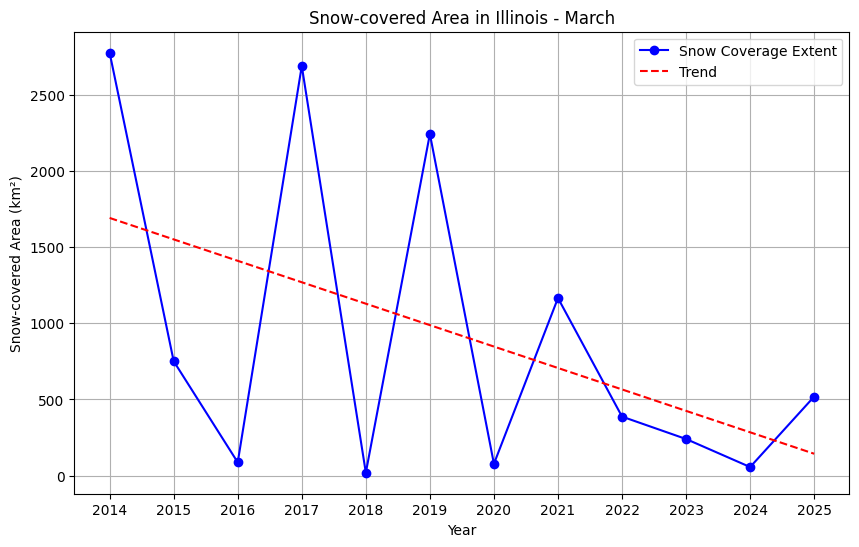

In [16]:
# Plot the snow area time series
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Snow_Area_km2'], marker='o', color='b', label ='Snow Coverage Extent')
plt.xlabel('Year')
plt.ylabel('Snow-covered Area (km²)')
plt.title('Snow-covered Area in Illinois - March')
plt.xticks(range(start_year, end_year + 1))
plt.grid(True)

# Linear trendline
x = df['Year'].dropna()
y = df['Snow_Area_km2'].dropna()

coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
plt.plot(x, trendline(x), color='r', linestyle='--', label='Trend')
plt.legend()

# Construct the full path to the folder in Google Drive
folder_path = '/content/drive/My Drive/GEE_Exports/'  # Replace with your folder name
file_name = 'snow_area_timeseries_mar_trend.jpg'
full_path = os.path.join(folder_path, file_name)

plt.savefig(full_path)  # Save the plot to the specified path

plt.show()

In [46]:
# Comment this back in when using in Colab - commented out so that notebook will display in github
# # Define the function to create the NDSI collection
# def create_ndsi_collection2():
#     # Load the Landsat 8 collection, apply cloud mask, and calculate NDSI
#     collection2 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
#                     .filterBounds(aoi) \
#                     .map(mask_clouds) \
#                     .map(calculate_ndsi2)
#     return collection2

# # Function to calculate NDSI (Normalized Difference Snow Index)
# def calculate_ndsi2(image2):
#     ndsi = image2.normalizedDifference(['SR_B3', 'SR_B6']).rename('NDSI')
#     return image2.addBands(ndsi)

# # def calculate_ndsi2(image2):
# #     ndsi = image2.expression(
# #         '(i.SR_B3 - i.SR_B6) / (i.SR_B3 + i.SR_B6)',  # NDSI formula
# #         {'i': image2}
# #     ).rename('NDSI')

# #     # Handle NaN values by replacing them with a specific value (e.g., -1)
# #     ndsi = ndsi.unmask(-1)

# #     return image2.addBands(ndsi)

# # Function to visualize a specific year's NDSI image
# def show_annual_ndsi2(year):
#     # Create the NDSI collection
#     ndsi_collection2 = create_ndsi_collection2()

#     # Filter the collection to the specified year and create a mosaic
#     year_start = ee.Date(f'{year}-01-01')
#     year_end = ee.Date(f'{year}-01-31')
#     annual_ndsi_image2 = (ndsi_collection2.filterDate(year_start, year_end)
#                          .select('NDSI')  # Select the NDSI band
#                          .mosaic()
#                          .clip(aoi))

#     # Use geemap to display the NDSI image
#     map = geemap.Map(basemap='HYBRID') #satellite basemap
#     map.addLayer(annual_ndsi_image2, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'NDSI {year}')
#     map.centerObject(aoi, 7)
#     map.addLayerControl()

#     # Add a colorbar to the map using geemap's built-in functionality
#     # This replaces the cartoee.add_colorbar which is not compatible with geemap.Map
#     map.add_colorbar(vis_params={'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']},
#                      label="NDSI",
#                      orientation="vertical",  # or "horizontal"
#                      layer_name=f'NDSI {year}') # Matches the layer name for clarity

#     # Return the map object to display it
#     return map  # Remove map.show() and just return the map object

# # Example: Show NDSI for 2018
# show_annual_ndsi2(2025) # Call the function to display the map

In [ ]:
# # Function to export NDSI images for multiple years to Google Drive
# def export_annual_ndsi_images(start_year, end_year, folder='GEE_Exports'):
#     for year in range(start_year, end_year + 1):
#         # Create the NDSI collection
#         ndsi_collection2 = create_ndsi_collection2()

#         # Filter the collection to the specified year and create a mosaic
#         year_start = ee.Date(f'{year}-01-01')
#         year_end = ee.Date(f'{year}-01-31')
#         annual_ndsi_image2 = (ndsi_collection2.filterDate(year_start, year_end)
#                              .select('NDSI')  # Select the NDSI band
#                              .mosaic()
#                              .clip(aoi))

#         # Export the image to Google Drive as JPG
#         task = ee.batch.Export.image.toDrive(
#             image=annual_ndsi_image2,
#             description=f'NDSI_{year}',  # Set the description/filename
#             scale=30,  # Adjust the scale as needed
#             region=aoi.geometry(),  # Set the region to your AOI
#             fileFormat='GeoTIFF',  # Change to your desired format if necessary
#             folder=folder  # Specify a folder in your Google Drive
#         )
#         task.start()
#         print(f'Exporting NDSI_{year} to Google Drive...')

# export_annual_ndsi_images(2014,2015) # Call the function to export images for multiple years

In [17]:
# Get the area of Illinois in square kilometers
illinois_area = aoi.geometry().area().divide(1e6).getInfo()  # Convert to sq km

In [18]:
# Calculate percentage snow cover for each year
df['Snow_Cover_Percentage'] = (df['Snow_Area_km2'] / illinois_area) * 100

print(df)

    Year  Snow_Area_km2  Snow_Cover_Percentage
0   2014    2774.337665               1.851621
1   2015     750.840373               0.501119
2   2016      87.174284               0.058181
3   2017    2687.384310               1.793588
4   2018      19.169496               0.012794
5   2019    2241.152325               1.495768
6   2020      77.511193               0.051732
7   2021    1164.908031               0.777472
8   2022     387.261188               0.258462
9   2023     240.302814               0.160381
10  2024      56.391068               0.037636
11  2025     518.677253               0.346171


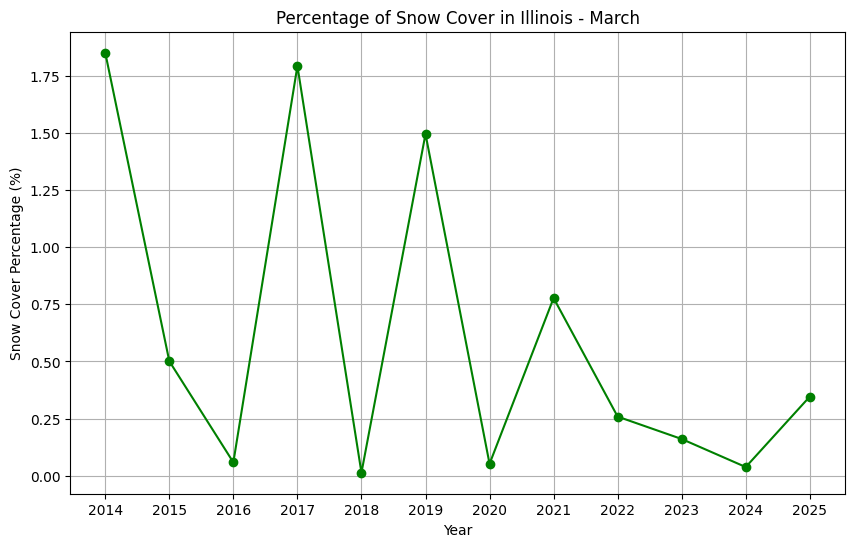

In [19]:
# Plot the percentage snow cover time series
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Snow_Cover_Percentage'], marker='o', color='g') # Changed color to green
plt.xlabel('Year')
plt.ylabel('Snow Cover Percentage (%)')
plt.title('Percentage of Snow Cover in Illinois - March')
plt.xticks(range(start_year, end_year + 1))
plt.grid(True)

# Construct the full path for saving the plot
file_name = 'snow_cover_percentage_timeseries_mar.jpg'  # New filename
full_path = os.path.join(folder_path, file_name)

plt.savefig(full_path)

plt.show()

In [27]:
# calc mean of snow area and snow area percent
mean_area = np.mean(df['Snow_Area_km2'].dropna())
mean_area_p = np.mean(df['Snow_Cover_Percentage'].dropna())

print(f'Mean Snow Area: {mean_area}')
print(f'Mean Snow Area Percent: {mean_area_p}')

# calc median of snow area and snow area percent
median_area = np.median(df['Snow_Area_km2'].dropna())
median_area_p = np.median(df['Snow_Cover_Percentage'].dropna())

print(f'Median Snow Area: {median_area}')
print(f'Median Snow Area Percent: {median_area_p}')

# calc standard deviation of the snow area and snow area percent
std_dev = np.std(df['Snow_Area_km2'].dropna())
std_dev_p = np.std(df['Snow_Cover_Percentage'].dropna())

print(f'Standard Deviation of Snow Area: {std_dev}')
print(f'Standard Deviation of Snow Area Percent: {std_dev_p}')

# calc min and max snow area
min_area = np.min(df['Snow_Area_km2'].dropna())
max_area = np.max(df['Snow_Area_km2'].dropna())

min_area_p = np.min(df['Snow_Cover_Percentage'].dropna())
max_area_p = np.max(df['Snow_Cover_Percentage'].dropna())

print(f'Minimum Snow Area: {min_area}')
print(f'Maximum Snow Area: {max_area}')
print(f'Minimum Snow Area Percent: {min_area_p}')
print(f'Maximum Snow Area Percent: {max_area_p}')

Mean Snow Area: 917.0924999432774
Mean Snow Area Percent: 0.6120769086149546
Median Snow Area: 452.96922038418575
Median Snow Area Percent: 0.30231628775464486
Standard Deviation of Snow Area: 1010.9283407850667
Standard Deviation of Snow Area Percent: 0.674703907945207
Minimum Snow Area: 19.169496050231935
Maximum Snow Area: 2774.33766453538
Minimum Snow Area Percent: 0.012793917606847997
Maximum Snow Area Percent: 1.8516213154811285


In [31]:
# calc 50th and 90th percentiles of snow area
percentile_50 = np.percentile(df['Snow_Area_km2'].dropna(), 50)
percentile_80 = np.percentile(df['Snow_Area_km2'].dropna(), 80)
percentile_90 = np.percentile(df['Snow_Area_km2'].dropna(), 90)

print(f'50th Percentile Snow Area: {percentile_50}')
print(f'80th Percentile Snow Area: {percentile_80}')
print(f'90th Percentile Snow Area: {percentile_90}')

50th Percentile Snow Area: 452.96922038418575
80th Percentile Snow Area: 2025.9034659374036
90th Percentile Snow Area: 2642.761111913248


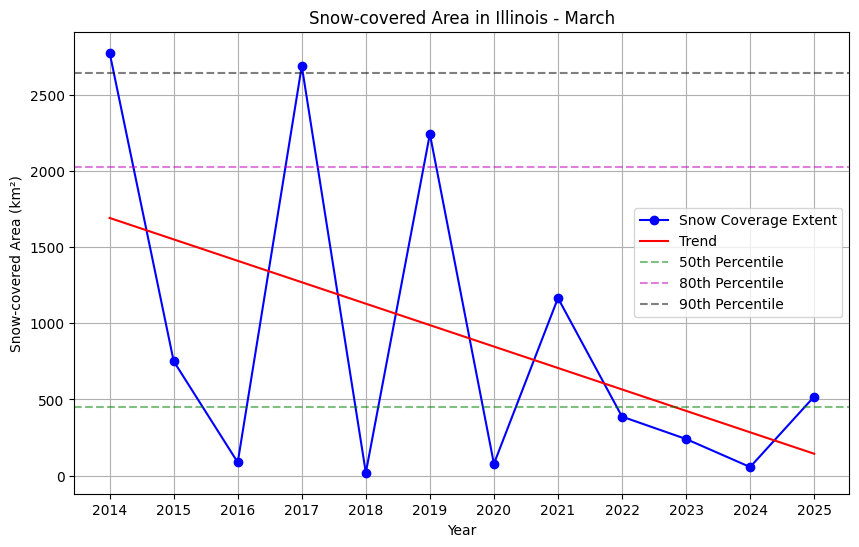

In [39]:
# Plot the snow area time series
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Snow_Area_km2'], marker='o', color='b', label ='Snow Coverage Extent')
plt.xlabel('Year')
plt.ylabel('Snow-covered Area (km²)')
plt.title('Snow-covered Area in Illinois - March')
plt.xticks(range(start_year, end_year + 1))
plt.grid(True)

# Linear trendline
x = df['Year'].dropna()
y = df['Snow_Area_km2'].dropna()

coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
plt.plot(x, trendline(x), color='r', linestyle='-', label='Trend')

# Plot percentiles
plt.axhline(y=percentile_50, color='g', linestyle='--', alpha=0.5, label='50th Percentile')
plt.axhline(y=percentile_80, color='m', linestyle='--', alpha=0.5, label='80th Percentile')
plt.axhline(y=percentile_90, color='k', linestyle='--', alpha=0.5, label='90th Percentile')

plt.legend()

# Construct the full path to the folder in Google Drive
folder_path = '/content/drive/My Drive/GEE_Exports/'  # Replace with your folder name
file_name = 'snow_area_timeseries_march_trend_percentile.jpg'
full_path = os.path.join(folder_path, file_name)

plt.savefig(full_path)  # Save the plot to the specified path

plt.show()

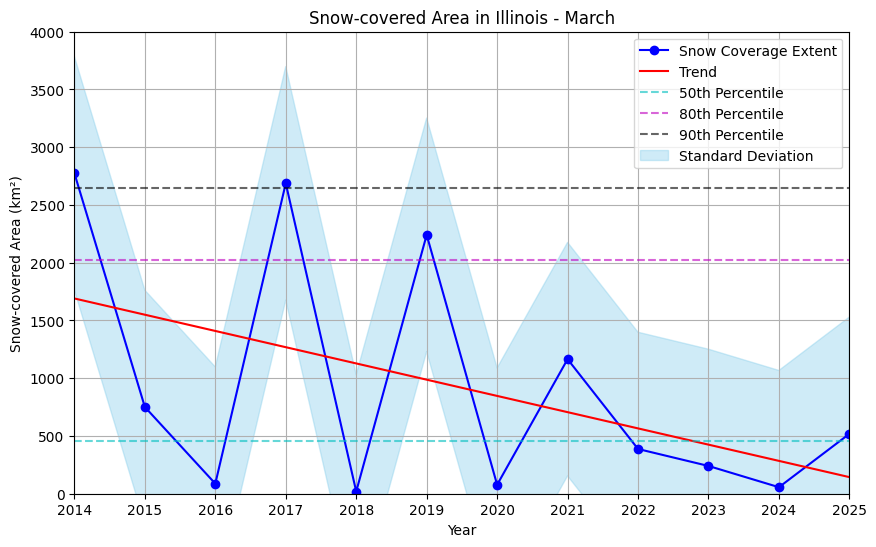

In [45]:
# plot the snow area time series with standard deviation shading
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Snow_Area_km2'], marker='o', color='b', label='Snow Coverage Extent')
plt.xlabel('Year')
plt.ylabel('Snow-covered Area (km²)')
plt.title('Snow-covered Area in Illinois - March')
plt.xticks(range(start_year, end_year + 1))
plt.grid(True)

# plot linear trendline
x = df['Year'].dropna()
y = df['Snow_Area_km2'].dropna()

coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
plt.plot(x, trendline(x), color='r', linestyle='-', label='Trend')

# plot percentiles
plt.axhline(y=percentile_50, color='c', linestyle='--', alpha=0.6, label='50th Percentile')
plt.axhline(y=percentile_80, color='m', linestyle='--', alpha=0.6, label='80th Percentile')
plt.axhline(y=percentile_90, color='k', linestyle='--', alpha=0.6, label='90th Percentile')

# calc upper and lower bounds for standard deviation shading
upper_bound = df['Snow_Area_km2'].dropna() + std_dev
lower_bound = df['Snow_Area_km2'].dropna() - std_dev

# fill area btwn the upper and lower bounds
plt.fill_between(x, lower_bound, upper_bound, color='skyblue', alpha=0.4, label='Standard Deviation')

plt.legend()

plt.xlim(2014, 2025)
plt.ylim(0, 4000)

# Construct the full path to the folder in Google Drive
folder_path = '/content/drive/My Drive/GEE_Exports/'
file_name = 'snow_area_timeseries_march_trend_stddev.jpg'
full_path = os.path.join(folder_path, file_name)

plt.savefig(full_path)  # save plot to specified path

plt.show()